_Toto je demonštratívne riešenie optimalizačného problému pomocou jazyku Julia a ide o druhú časť tutoriálu_ [Julia-getting started](julia_getting_started.ipynb).

# Support Vector Machine optimization problem

## Teoretický úvod

V tomto zápisníku si naprogramujeme optimalizačný problém **Support Vector Machine(SVM)**, teda metódu podporných vektorov. Naša úloha je [klasifikovať](https://cs.wikipedia.org/wiki/Klasifikace_(um%C4%9Bl%C3%A1_inteligence)) dáta do 2 skupín na základe nášho vstupného trénovacieho datasetu, teda množiny, už takto oklasifikovaných dát. Túto úlohu z demonštratívnych dôvodov skonštruujeme v 2D.

Predstavme si teda, že máme trénovací dataset, ktorý vieme jednoznačne rozdeliť na dve skupiny dát, povedzme s vlastnosťou $y_1$ a $y_2$. Celá táto úloha slúži na vytvorenie modelu, pomocou ktorého budeme môcť rôzne dáta oklasifikovať, teda rozhodnúť, či majú vlastnosť $y_1$ alebo $y_2$.

Rozdelený dataset s vlastnosťami $y_1$ a $y_2$  v 2D môžeme interpretovať ako 2 množiny bodov v rovine:

Príklad v $R^2$:<img src="images/img1.png" style="width: 400px;">

Na klasifikáciu dát použijeme [lineárny klasifikátor](https://en.wikipedia.org/wiki/Linear_classifier) a pokúsime sa náš trénovací dataset rozdeliť nadrovinou(v 2D priamka), tak aby, čo najlepšie rozdeľovala dáta s vlastnosťou $y_1$ od dát s vlasnosťou $y_2$. Nadrovín, ktoré rozdeľujú dáta môže byť viac:
<img src="images/img2.png" style="width: 400px;">

Náš cieľ je teda nájsť rovnicu priamky, ktorá najlepšie oddeľuje tieto 2 skupiny bodov. Rovnica nadroviny $H_i$ je $\underline{\omega_i}\cdot\underline{x}+b_i=0$, kde $\underline{\omega_i}$ je normálový vektor danej nadroviny a $\underline{x}$ je ľubovolný bod z uvažovaného priestoru. Táto rovnica v 2D splýva s rovnicou priamky $ax+by+c=0$

Nech existuje nami hľadaná nadrovina rozdeĺujúca náš dataset s rovnicou $\underline{\omega}\cdot\underline{x}+b=0$. Potom môžeme zadefinovať nadroviny na hraniciach $y_1$ množiny a $y_2$ množiny, ako:
$$\underline{\omega_{y_1}}\cdot\underline{x}+b_{y_1}=\delta$$
$$\underline{\omega_{y_2}}\cdot\underline{x}+b_{y_2}=-\delta$$

Pre zjednodušenie môžeme za $\delta$ položiť $1$ a ilustrovať to na nasledujúcom obrázku:

<img src="images/img3.png" style="width: 400px;">

Po [odvodení](https://www.svm-tutorial.com/2015/06/svm-understanding-math-part-3/), ktoré pre krátkosť a zameranie tohto textu nebudeme uvádzať, zistíme, že šírka pásu oddeľujúceho tieto 2 nadroviny je $\frac{2}{||\omega||}$. Ak chceme maximalizovať šírku tohto pásu, musíme minimalizovať prevrátenú hodnotu, teda $\frac{1}{2}||\omega||$. Tak sa konečne dostávame k samotnej optimalizačnej úlohe.

## Formulácia problému

Položme 
$$
 f(\underline{x}) =\begin{cases}
    1       & \quad \text{ak } \underline{x}\in y_1 (\text{má vlasnosť }y_1)\\
    -1      & \quad \text{ak } \underline{x}\in y_2 (\text{má vlasnosť }y_2)\end{cases}
$$
čím matematicky vyjadríme príslušnosť bodu k množine s danou vlastnosťou. Potom môžeme náš optimalizačný problém pre $n$ bodov zadefinovať nasledovne:

$${\text{minimize}} \quad\frac{1}{2}||\omega||^2$$
$${\text{subject to}} \quad f(\underline{x_i})(\underline{\omega}\cdot\underline{x_i}+b) \ge 1\qquad for\ i = 1,\ldots,n$$

Kvadrátom $\omega$ zaručíme konvexnosť problém, a teda jedinečné globálne minimum, $\underline{\text{ak existuje}}$. Nemáme totiž zaručenú existenciu riešenia. Tento model sa nazýva tzv. "_Hard Margin SVM_"

Teraz už len ostáva to naprogramovať a nechať Juliu robiť svoju práci.

## Implementácia v Julii

### Vstupné dáta - trénovací dataset a jeho zobrazenie pomocou balíčku Plots

Najprv vygenerujeme náš testovací dataset. Použijeme na to pomocnú funkciu zadefinovanú v inom Julia súbore. Všetky 3 pomocné funkcie použité v tomto deme si môžete pozrieť [tu](SVM_utils_jl.ipynb).

In [1]:
include("SVM_utils.jl")
accurancy = 10e-2

y1_data_first = generate_2D_dataset(5, (0,4), (0, 5), accurancy)
y1_data_between = generate_2D_dataset(10, (5,15), (4, 8), accurancy)
y1_data_last = generate_2D_dataset(5, (16,20), (9, 15), accurancy )
y1_data = [y1_data_first; y1_data_between; y1_data_last]

y2_data_first = generate_2D_dataset(5, (0,4), (9, 15), accurancy)
y2_data_between = generate_2D_dataset(10, (5,15), (12, 19), accurancy)
y2_data_last = generate_2D_dataset(5, (16,20), (16, 18), accurancy )
y2_data = [y2_data_first; y2_data_between; y2_data_last];

**POZNÁMKA**: _Pozor, ak si skúšate generovať nové vlastné dáta interaktívnym spustením tohto bloku kódu, je možné, že takto vygenerované dáta nebude možné lineárne rozdeliť a žiadne prípustné riešenie nebude existovať. Každopádne, aj v tom prípade je zaujímavé vidieť, čo sa stane a ako to dopadne s naším problémom. Eventuálne spúšťajte kód "kým sa to nepodarí"._


Keď nami náhodne vygenerované dáta hodíme do grafu, vyzerá to takto: 

In [2]:
using Plots
gr() #choosing backend for plotting

x1_data = [y1_data[:,1] y2_data[:,1]]
x2_data = [y1_data[:,2] y2_data[:,2]]
labels = ["feature 'y1'" "feature 'y2'"]
x1_domain, x2_domain = get_minmax_vals([y1_data;y2_data])

([0.0, 19.0], [0.2, 18.7])

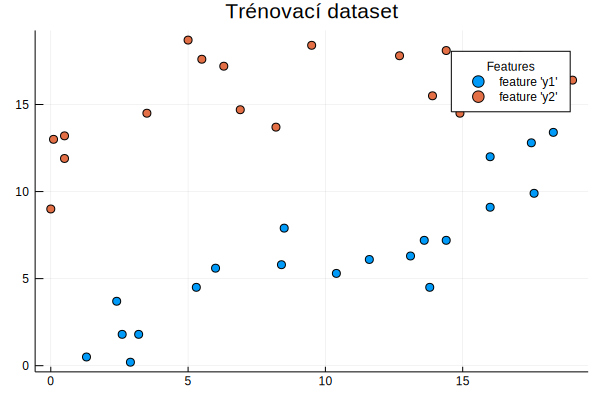

In [3]:
plot(x1_data, x2_data, xlims=x1_domain, ylims=x2_domain, label=labels, legendtitle="Features", seriestype=:scatter, title="Trénovací dataset")

### Formulácia problému s optimalizačnou knižnicou Convex

Máme trénovací dataset, takže môžeme pristúpiť k formulácii problému.
Ako prvé zadefinujeme **optimalizačné premenné** $\omega$ a $b$, aj s ich dimenziami, **účelovú funkciu** $\frac{1}{2}||\omega||^2$ a problém samotný:

In [4]:
using Convex

omega = Variable(1,2)
b = Variable(1,1)
objective = sumsquares(omega)/2 #sumsquares(x) = ||x||^2 with Euclidian norm
problem = minimize(objective)

Problem:
minimize AbstractExpr with
head: *
size: (1, 1)
sign: Positive()
vexity: ConvexVexity()

subject to

current status: not yet solved

Teraz budeme iterovať cez body nášho datasetu a definovať **obmedzenie** $$f(\underline{x_i})(\underline{\omega}\cdot\underline{x_i}+b) \ge 1\qquad for\ i = 1,\ldots,n$$

In [5]:
data = Dict(1 => y1_data, -1 => y2_data)

constraints = []
for (y, dataset) in data
    points_number = size(dataset)[1]
    for point_index in collect(1:points_number)
        x = dataset[point_index, :]
        problem.constraints +=  y*(omega*x+b) >= 1
    end
end

### Riešenie úlohy pomocou riešiča ECOS

Teraz už len vyriešíme našu úlohu, a to pomocou riešiča $ECOS$.

In [6]:
using ECOS

solve!(problem, ECOSSolver())



ECOS 2.0.5 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  +1.398e+01  +5e+01  7e-01  1e+00  1e+00  1e+00    ---    ---    1  1  - |  -  - 
 1  +5.284e-01  +4.685e+00  +1e+01  2e-01  7e-01  4e-01  3e-01  0.8600  7e-02   1  1  1 |  0  0
 2  +4.243e-01  +1.302e+00  +3e+00  3e-02  2e-01  5e-02  6e-02  0.7799  4e-02   1  1  1 |  0  0
 3  +3.013e-01  +4.511e-01  +7e-01  5e-03  2e-02  1e-02  2e-02  0.7808  4e-02   2  2  2 |  0  0
 4  +3.358e-01  +3.838e-01  +2e-01  2e-03  7e-03  4e-03  5e-03  0.8781  2e-01   2  1  1 |  0  0
 5  +3.396e-01  +3.457e-01  +3e-02  2e-04  9e-04  5e-04  6e-04  0.9335  7e-02   2  1  1 |  0  0
 6  +3.394e-01  +3.397e-01  +1e-03  1e-05  5e-05  3e-05  3e-05  0.9447  8e-04   2  1  1 |  0  0
 7  +3.394e-01  +3.394e-01  +2e-05  2e-07  8e-07  5e-07  5e-07  0.9890  5e-03   3  1  1 |  0  0
 8  +3.394e-01  +3.394e-01  +4e-07  3e-09  1e-

Môžeme sa pozrieť na výsledok problému, hodnotu účelovej funkcie a optimalizačných premenných:

In [7]:
println(problem.status, "\n\n", problem.optval, "\n\n", omega, "\n\n", b )

Optimal

0.3393692418762612

Variable of
size: (1, 2)
sign: NoSign()
vexity: AffineVexity()
value: [0.346399 -0.747493]

Variable of
size: (1, 1)
sign: NoSign()
vexity: AffineVexity()
value: 4.677301731809577


### Zhrnutie výsledkov

Vyriešili sme náš optimalizačný problém a našli sme **optimálne riešenie**. Poďme naše výsledky demonštrovať na predchádzajúcom grafe a zakresliť doňho oddeľujúcu nami nájdenú nadrovinu. 

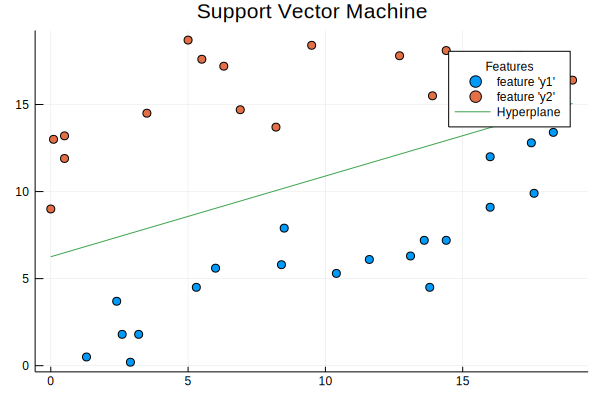

In [8]:
hyperplane = create_2D_linear_function(omega.value, b.value)
line_x_data = collect(x1_domain[1]:0.01:x1_domain[2])
line_y_data = hyperplane.(line_x_data)
plot!(line_x_data, line_y_data, label=["Hyperplane"], seriestype=:line, title="Support Vector Machine")

Ako vidíme, všetko funguje ako má a naše 2 skupiny bodov s vlastnosťami $y_1$ a $y_2$ sú jednoznačne oddelené našou nadrovinou. Keď teraz dostaneme za úlohu rozhodnúť, ktorú vlastnosť má nejaký bod z tohto priestoru, môžeme na to využiť tento model a priradiť mú vlastnosť podľa toho, na ktorej strane(priestoru oddeľovaného nadrovinou) sa nachádza.

Úplne rovnaký postup pre nájdenie optimálnej nadroviny by sme mohli zvoliť pre **ľubovoľnú** dimenziu nielen 2D.

Existenciu riešenia sme zaručenú nemali. Sú však variácie tohto problému, kde pomocou dodatočne zadefinovaných umelých premenných môžeme relaxovať optimalizačné obmedzenia a aj keď dáta nevieme lineárne separovať, stále vieme nájsť nadrovinu "kvázi" vyhovujúcu naším potrebám. Ide o tzv. "_Soft Margin SVM_"

Sú rôzne variácie SVM. Body sa dajú separovať aj nelineárne, prípadne môžeme penalizovať isté faktory, čím dokážeme model lepšie napasovať na náš problém. Vo všeobecnosti má SVM rôznorodé aplikácie naprieč spektrom odvetví.

## Záver

Opdorúčam, aby ste si pomenili parametre funkcií, poskúšali rôzne situácie a precvičili si tak Juliu. Prípadne model rozšírili na [soft-margin](https://www.saedsayad.com/support_vector_machine.htm) alebo si skúsili naprogramovať vlastnú optimalizačnú úlohu alebo skriptík v Julii. Ak uvažujete v pokračovaní v online precvičovaní Julie, vyskúšajte [JuliaBox](https://juliabox.com/), je zadarmo, len sa musíte prihlásiť, napríklad e-mailom.